# SQL in Python - Connecting to and retrieving data from PostgreSQL

Previously, you have learned how to connect to a SQL database by using a SQL client such as DBeaver. Apart from connecting to databases, DBeaver also allows you to run SQL queries against the database, create new tables and populate them with data as well as retrieving the data.

Python also allows executing SQL queries and getting the result into a Python object, for example a Pandas data frame. Instead of exporting a .csv file from DBeaver you can directly get the data you need into Python and continue your work. In addition we can reduce the steps by connecting to the database from Python directly, eliminating the need for a separate SQL client.

After you have the data in Python in the required shape you can export the data into a .csv file. This file is for your own reference, please avoid sending .csv files around - database is the point of reference when it comes to data. 

Having a copy of a .csv file (or another format) can speed up your analysis work. Imagine that the query takes 25 minutes to run. If you made some mistakes in your Python code you might need to go back to the original dataset. Instead of having to rerun the SQL query and having to wait you can read in the .csv file you have previously saved on your hard disk into Python and continue with your analysis work. 

**In this notebook you will see 2 ways to connect to SQL-Databases and export the data to a CSV file**


## Creating a connection to a PostgreSQL database with Python

There are 2 python packages that are the "go-to" when it comes to connecting to SQL-Databases: `psycopg2` and `sqlalchemy` 

### Connecting via psycopg2

In [92]:
import pandas as pd
import psycopg2


In order to create a connection to our PostgreSQL database we need the following information:

- host = the address of the machine the database is hosted on
- port = the virtual gate number through which communication will be allowed
- database = the name of the database
- user = the name of the user
- password = the password of the user

Because we don't want that the database information is published on github we put it into a `.env` file which is added into the `.gitignore`. 
In these kind of files you can store information that is not supposed to be published.
With the `dotenv` package you can read the `.env` files and get the variables.
(We will share the file with you on Slack!)


In [93]:
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

The function from the psycopg2 package to create a connection is called `connect()`.
`connect()` expects the parameters listed above as input in order to connect to the database.

In [94]:
# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

### Retrieving data from the database with psycopg2

Before we can use our connection to get data, we have to create a cursor. A cursor allows Python code to execute PostgreSQL commmands in a database session.
A cursor has to be created with the `cursor()` method of our connection object conn.

In [95]:
cur = conn.cursor()

Now we can run SQL-Queries with `cur.execute('QUERY')` and then run `cur.fetchall()` to get the data:

In [96]:
cur.execute('SELECT * FROM eda.king_county_house_sales LIMIT 10')
cur.fetchall()

[(datetime.date(2014, 10, 13), 221900.0, 7129300520, 1),
 (datetime.date(2014, 12, 9), 538000.0, 6414100192, 2),
 (datetime.date(2015, 2, 25), 180000.0, 5631500400, 3),
 (datetime.date(2014, 12, 9), 604000.0, 2487200875, 4),
 (datetime.date(2015, 2, 18), 510000.0, 1954400510, 5),
 (datetime.date(2014, 5, 12), 1230000.0, 7237550310, 6),
 (datetime.date(2014, 6, 27), 257500.0, 1321400060, 7),
 (datetime.date(2015, 1, 15), 291850.0, 2008000270, 8),
 (datetime.date(2015, 4, 15), 229500.0, 2414600126, 9),
 (datetime.date(2015, 3, 12), 323000.0, 3793500160, 10)]

With `conn.close()` you can close the connection again.

In [97]:
#close the connection
conn.close()

But we want to work with the data. The easiest way is to import the data into pandas dataframes. We can use `pd.read_sql_query` or `pd.read_sql_table` or for convenience `pd.read_sql`.

This function is a convenience wrapper around read_sql_table and read_sql_query (for backward compatibility). It will delegate to the specific function depending on the provided input. A SQL query will be routed to read_sql_query , while a database table name will be routed to read_sql_table . Note that the delegated function might have more specific notes about their functionality not listed here.

In [98]:
# Open connection again because we closed it
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

In [99]:
# import the data into a pandas dataframe
query_string = "SELECT * FROM eda.king_county_house_sales LIMIT 10"
df_psycopg = pd.read_sql(query_string, conn)

/tmp/ipykernel_5030/1176423828.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(query_string, conn)


In [100]:
# import the data into a pandas dataframe
real_estate_shark = """
SELECT kchd.*, kchs."date", kchs.price
FROM eda.king_county_house_details AS kchd
LEFT JOIN eda.king_county_house_sales AS kchs
ON kchd.id = kchs.house_id;
"""

df_psycopg = pd.read_sql(real_estate_shark, conn)

/tmp/ipykernel_5030/3444704057.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(real_estate_shark, conn)


In [101]:
#close the connection
conn.close()

In [102]:
df_psycopg.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0


In [103]:
#export the data to a csv-file
df_psycopg.to_csv('data/eda.csv',index=False)

### Connecting and retrieving data via SQLAlchemy

`sqlalchemy` works similarly. Here you have to create an engine with the database sting (a link that includes every information we entered in the conn object)

In [104]:
from sqlalchemy import create_engine

#read the database string from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

And then you can import that engine with a query into a pandas dataframe.

In [105]:
#import the data to a pandas dataframe
query_string = """
SELECT kchd.*, kchs."date", kchs.price
FROM eda.king_county_house_details AS kchd
LEFT JOIN eda.king_county_house_sales AS kchs
ON kchd.id = kchs.house_id;
"""
df = pd.read_sql(query_string, db)

In [106]:
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0


Because we don't want to run the queries over and over again we can export the data into a .csv file in order to use it in other notebooks as well. 

In [107]:
#export the data to a csv-file
df.to_csv('eda.csv',index=False)

In [108]:
#import the data from a csv-file
df = pd.read_csv('data/eda.csv')

In [109]:
# Get an overview

In [110]:

df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0


In [111]:
df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19206.000000,21534.000000,21597.000000,21597.000000,21597.000000,21145.000000,21597.000000,17749.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007602,0.233863,3.409825,7.657915,1788.596842,291.857224,1970.999676,836.650516,98077.951845,47.560093,-122.213983,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086858,0.765686,0.650546,1.173200,827.759761,442.490863,29.375234,4000.110554,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,20150.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


In [112]:
df.dtypes

id                 int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
date              object
price            float64
dtype: object

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

data cleaning

In [114]:
df.isnull().sum()

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

Only relevant columns

In [115]:
# > 1 column or df]]
res = df[['price', 'sqft_living', 'yr_built', 'yr_renovated', 'condition', 'grade', 'zipcode', 'date']].copy()

In [116]:
print (res.dtypes)


price           float64
sqft_living     float64
yr_built          int64
yr_renovated    float64
condition         int64
grade             int64
zipcode           int64
date             object
dtype: object


In [117]:
# change datatyp date
res['date'] = pd.to_datetime(res['date'])

In [118]:
print (res.dtypes)


price                  float64
sqft_living            float64
yr_built                 int64
yr_renovated           float64
condition                int64
grade                    int64
zipcode                  int64
date            datetime64[ns]
dtype: object


In [119]:
res.describe()

,price,sqft_living,yr_built,yr_renovated,condition,grade,zipcode,date
count,2.159700e+04,21597.000000,21597.000000,17749.000000,21597.000000,21597.000000,21597.000000,21597
mean,5.402966e+05,2080.321850,1970.999676,836.650516,3.409825,7.657915,98077.951845,2014-10-29 04:20:38.171968512
min,7.800000e+04,370.000000,1900.000000,0.000000,1.000000,3.000000,98001.000000,2014-05-02 00:00:00
25%,3.220000e+05,1430.000000,1951.000000,0.000000,3.000000,7.000000,98033.000000,2014-07-22 00:00:00
50%,4.500000e+05,1910.000000,1975.000000,0.000000,3.000000,7.000000,98065.000000,2014-10-16 00:00:00
75%,6.450000e+05,2550.000000,1997.000000,0.000000,4.000000,8.000000,98118.000000,2015-02-17 00:00:00
max,7.700000e+06,13540.000000,2015.000000,20150.000000,5.000000,13.000000,98199.000000,2015-05-27 00:00:00
std,3.673681e+05,918.106125,29.375234,4000.110554,0.650546,1.173200,53.513072,NaN


In [120]:
#NaN?
res.isnull().sum()

price              0
sqft_living        0
yr_built           0
yr_renovated    3848
condition          0
grade              0
zipcode            0
date               0
dtype: int64

In [121]:
#NaN = 0 no renovated
res['yr_renovated'] = res['yr_renovated'].fillna(0)

In [122]:
res.isnull().sum()

price           0
sqft_living     0
yr_built        0
yr_renovated    0
condition       0
grade           0
zipcode         0
date            0
dtype: int64

In [123]:
res.shape

(21597, 8)

In [124]:
#check > 2025 yr renovated
print(res[res["yr_renovated"] > 2025])

           price  sqft_living  yr_built  yr_renovated  condition  grade  \
1       538000.0       2570.0      1951       19910.0          3      7   
35      696000.0       2300.0      1930       20020.0          3      8   
95      905000.0       3300.0      1946       19910.0          3      7   
103    1090000.0       2920.0      1950       20100.0          3      8   
125    1450000.0       2750.0      1914       19920.0          3      8   
...          ...          ...       ...           ...        ...    ...   
19602   451000.0        900.0      1944       20040.0          3      7   
20041   434900.0       1520.0      1977       20060.0          3      7   
20428   500012.0       2400.0      1962       20090.0          3      8   
20431   356999.0       1010.0      1971       20140.0          3      8   
20946   110000.0        828.0      1968       20070.0          3      6   

       zipcode       date  
1        98125 2014-12-09  
35       98115 2014-06-13  
95       98040 

In [125]:
#check 1900 -2025
res[(res["yr_renovated"] >= 1900) & (res["yr_renovated"] <= 2025)]

,price,sqft_living,yr_built,yr_renovated,condition,grade,zipcode,date


In [126]:
res["yr_renovated"] = res["yr_renovated"].apply(lambda x: int(x) // 10 if x > 9999 else int(x))

In [127]:
print(res["yr_renovated"].min(), res["yr_renovated"].max())

0 2015


In [128]:
res.describe()

,price,sqft_living,yr_built,yr_renovated,condition,grade,zipcode,date
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597
mean,5.402966e+05,2080.321850,1970.999676,68.758207,3.409825,7.657915,98077.951845,2014-10-29 04:20:38.171968512
min,7.800000e+04,370.000000,1900.000000,0.000000,1.000000,3.000000,98001.000000,2014-05-02 00:00:00
25%,3.220000e+05,1430.000000,1951.000000,0.000000,3.000000,7.000000,98033.000000,2014-07-22 00:00:00
50%,4.500000e+05,1910.000000,1975.000000,0.000000,3.000000,7.000000,98065.000000,2014-10-16 00:00:00
75%,6.450000e+05,2550.000000,1997.000000,0.000000,4.000000,8.000000,98118.000000,2015-02-17 00:00:00
max,7.700000e+06,13540.000000,2015.000000,2015.000000,5.000000,13.000000,98199.000000,2015-05-27 00:00:00
std,3.673681e+05,918.106125,29.375234,364.037499,0.650546,1.173200,53.513072,NaN


In [129]:
res.shape

(21597, 8)

In [130]:
# duplicates?
res.duplicated().value_counts()
# remove
res = res.drop_duplicates()
# reset index
res.reset_index(inplace=True, drop=True)




In [131]:
#check zipcode (Bruce Lee 98104:))
print(res['zipcode'].unique()) 

[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


In [132]:
res.head()

,price,sqft_living,yr_built,yr_renovated,condition,grade,zipcode,date
0,221900.0,1180.0,1955,0,3,7,98178,2014-10-13
1,538000.0,2570.0,1951,1991,3,7,98125,2014-12-09
2,180000.0,770.0,1933,0,3,6,98028,2015-02-25
3,604000.0,1960.0,1965,0,5,7,98136,2014-12-09
4,510000.0,1680.0,1987,0,3,8,98074,2015-02-18


In [133]:
res.describe()

,price,sqft_living,yr_built,yr_renovated,condition,grade,zipcode,date
count,2.159500e+04,21595.000000,21595.000000,21595.000000,21595.000000,21595.000000,21595.000000,21595
mean,5.403033e+05,2080.233897,1970.997314,68.764575,3.409863,7.657884,98077.954063,2014-10-29 04:32:43.787914240
min,7.800000e+04,370.000000,1900.000000,0.000000,1.000000,3.000000,98001.000000,2014-05-02 00:00:00
25%,3.220000e+05,1430.000000,1951.000000,0.000000,3.000000,7.000000,98033.000000,2014-07-22 00:00:00
50%,4.500000e+05,1910.000000,1975.000000,0.000000,3.000000,7.000000,98065.000000,2014-10-16 00:00:00
75%,6.450000e+05,2550.000000,1997.000000,0.000000,4.000000,8.000000,98118.000000,2015-02-17 00:00:00
max,7.700000e+06,13540.000000,2015.000000,2015.000000,5.000000,13.000000,98199.000000,2015-05-27 00:00:00
std,3.673843e+05,918.099469,29.375140,364.053756,0.650564,1.173249,53.515050,NaN


In [134]:
res.dtypes

price                  float64
sqft_living            float64
yr_built                 int64
yr_renovated             int64
condition                int64
grade                    int64
zipcode                  int64
date            datetime64[ns]
dtype: object

In [135]:
# calculation relative measure pps = price per sqft_living
res['pps'] = res['price'] / res['sqft_living']
columns_order = ['price', 'sqft_living', 'pps', 'yr_built', 'yr_renovated', 'condition', 'grade', 'zipcode', 'date']
res = res[columns_order]

In [136]:
# create new column ranovated vs not
res['renovated'] = res['yr_renovated'] != 0

In [137]:
res.describe()

,price,sqft_living,pps,yr_built,yr_renovated,condition,grade,zipcode,date
count,2.159500e+04,21595.000000,21595.000000,21595.000000,21595.000000,21595.000000,21595.000000,21595.000000,21595
mean,5.403033e+05,2080.233897,264.153545,1970.997314,68.764575,3.409863,7.657884,98077.954063,2014-10-29 04:32:43.787914240
min,7.800000e+04,370.000000,87.588235,1900.000000,0.000000,1.000000,3.000000,98001.000000,2014-05-02 00:00:00
25%,3.220000e+05,1430.000000,182.294902,1951.000000,0.000000,3.000000,7.000000,98033.000000,2014-07-22 00:00:00
50%,4.500000e+05,1910.000000,244.656918,1975.000000,0.000000,3.000000,7.000000,98065.000000,2014-10-16 00:00:00
75%,6.450000e+05,2550.000000,318.350340,1997.000000,0.000000,4.000000,8.000000,98118.000000,2015-02-17 00:00:00
max,7.700000e+06,13540.000000,810.138889,2015.000000,2015.000000,5.000000,13.000000,98199.000000,2015-05-27 00:00:00
std,3.673843e+05,918.099469,110.000071,29.375140,364.053756,0.650564,1.173249,53.515050,NaN


In [138]:
res.head

<bound method NDFrame.head of           price  sqft_living         pps  yr_built  yr_renovated  condition  \
0      221900.0       1180.0  188.050847      1955             0          3   
1      538000.0       2570.0  209.338521      1951          1991          3   
2      180000.0        770.0  233.766234      1933             0          3   
3      604000.0       1960.0  308.163265      1965             0          5   
4      510000.0       1680.0  303.571429      1987             0          3   
...         ...          ...         ...       ...           ...        ...   
21590  360000.0       1530.0  235.294118      2009             0          3   
21591  400000.0       2310.0  173.160173      2014             0          3   
21592  402101.0       1020.0  394.216667      2009             0          3   
21593  400000.0       1600.0  250.000000      2004             0          3   
21594  325000.0       1020.0  318.627451      2008             0          3   

       grade  zipcode

In [139]:
# save clean data
res.to_csv('res.csv',index=False)

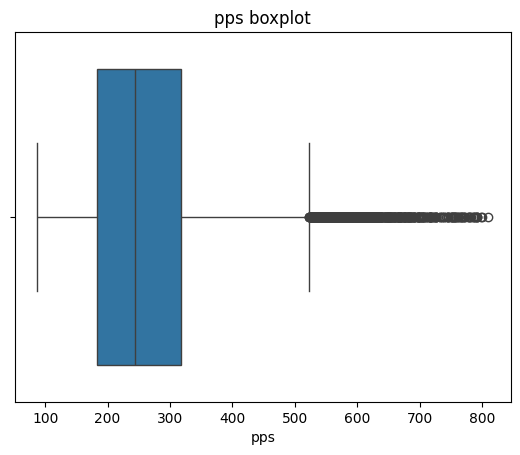

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

#boxplot pps

sns.boxplot(x=res["pps"])
plt.title('pps boxplot')

plt.show()

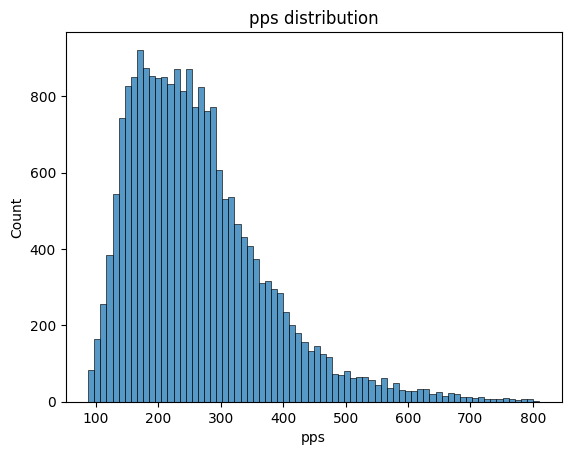

In [141]:
sns.histplot(res['pps'])
plt.title('pps distribution')
plt.show()
#left-skewed distribution If you are looking to invest and there is a left-skewed distribution of property prices,
#  high-priced properties (those located towards the right of the distribution) may offer higher returns because they are less common and can often appreciate in value.

Hypothese 1: Renovation Increases Selling Price

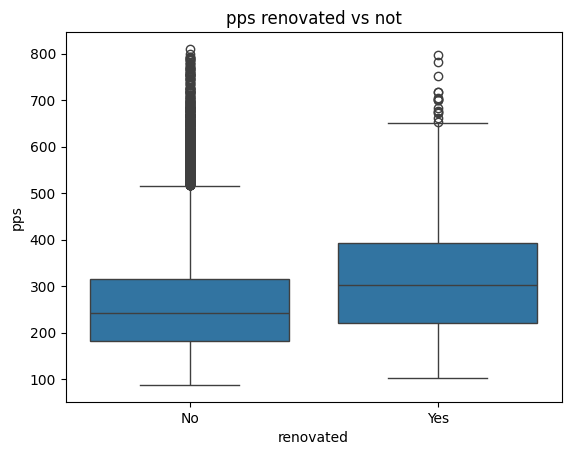

In [142]:
sns.boxplot(x='renovated', y='pps', data=res)
plt.title('pps renovated vs not')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()



In [143]:
mean_prices = res.groupby('renovated')['pps'].mean()
print(mean_prices)

renovated
False    262.113100
True     321.338135
Name: pps, dtype: float64


In [144]:
diff_percent = (mean_prices[True] - mean_prices[False]) / mean_prices[False] * 100
print(f"Renovated houses are {diff_percent:.2f}% more expensive on average.")

Renovated houses are 22.60% more expensive on average.


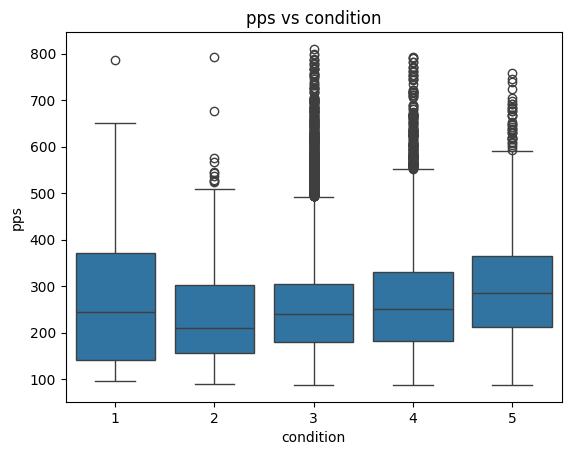

In [145]:
sns.boxplot(x='condition', y='pps', data=res)
plt.title('pps vs condition')
plt.show()
#condition influences pps, but 1 also good renovation potential

Text(0.5, 1.0, 'grade vs pps')

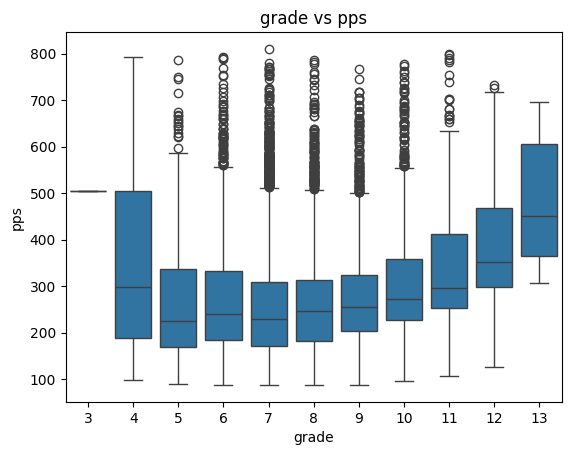

In [146]:
sns.boxplot(x='grade', y='pps', data=res)
plt.title('grade vs pps')
# higher pps with grade


Text(0.5, 1.0, 'pps vs built year')

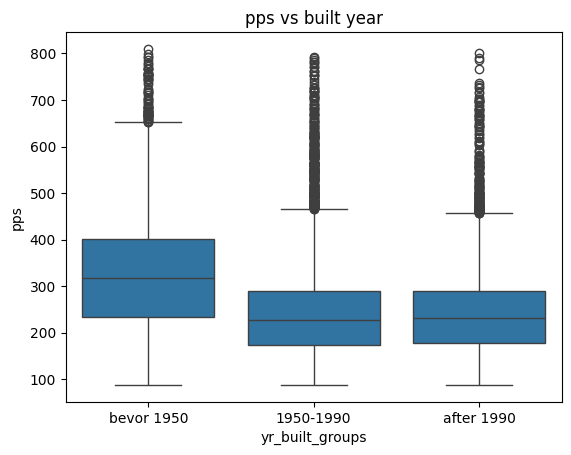

In [147]:
res['yr_built_groups'] = pd.cut(res['yr_built'], bins=[1900, 1950, 1990, 2025], labels=['bevor 1950', '1950-1990', 'after 1990'])
sns.boxplot(x='yr_built_groups', y='pps', data=res)
plt.title('pps vs built year')
#historical value higher pps if its older

In [148]:
correlation = res[['renovated', 'pps']].corr().round(2)
print(correlation)
# correlation 0.1 < 0.5 => not significant

           renovated  pps
renovated        1.0  0.1
pps              0.1  1.0


In [149]:
correlation = res[['renovated', 'pps']].corr(method = 'spearman').round(2)
print(correlation)

           renovated   pps
renovated       1.00  0.09
pps             0.09  1.00


In [150]:
import scipy.stats as stats

# Group 1: Houses that were renovated
renovated_houses = res[res['renovated'] == 1]['pps']

# Group 2: Houses that were not renovated
non_renovated_houses = res[res['renovated'] == 0]['pps']

# Perform the t-test (two independent samples)
t_stat, p_value = stats.ttest_ind(renovated_houses, non_renovated_houses, equal_var=False)

# Output the results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpretation of the result
alpha = 0.01  # Significance level

if p_value < alpha:
    print("Null hypothesis is rejected: Renovations increase the selling price.")
else:
    print("Null hypothesis is not rejected: Renovations have no impact on the selling price.")

T-Statistic: 12.12837561505418
P-Value: 3.9090687418911933e-31
Null hypothesis is rejected: Renovations increase the selling price.


T is high P => difference statisticaly significant > 2, is Low => low probability reject H0 > 0.05

Hypothese 1 Inside pps is higher with renovation, T-Statistic show significant. Further evalutation => check with multiple regression

Recomendation 1 buy at condition 2 and renovate sell on 5. 1 is expensive in pps. Renovated houses are 22.60% more expensive on average. Fix and flip mostly works. 


Hypothese 2: Location (Zipcode) Impacts ROI

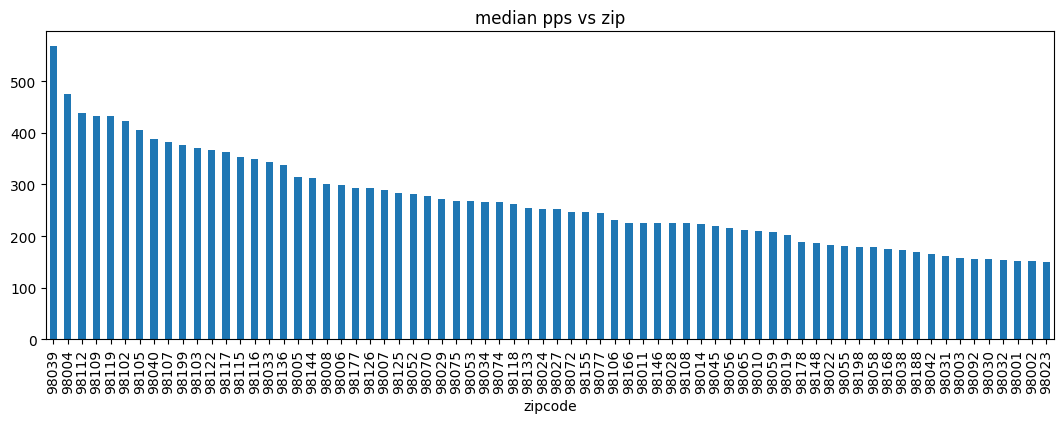

In [151]:
avg_price_zip = res.groupby('zipcode')['pps'].mean().sort_values(ascending=False)
avg_price_zip.plot(kind='bar', figsize=(13, 4), title='median pps vs zip')
plt.show()

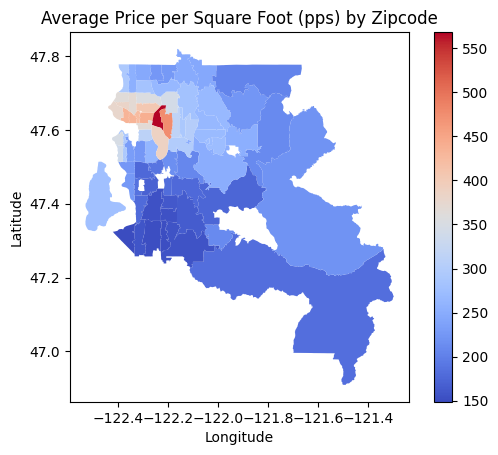

In [152]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Geodata (GeoJSON) 
map_df = gpd.read_file('data/seattle_zip_codes_geo.json') 

# to str 
avg_price_zip.index = avg_price_zip.index.astype(str)  # Convert index to string (zipcode)
map_df['ZCTA5CE10'] = map_df['ZCTA5CE10'].astype(str)  # Convert ZCTA5CE10 to string (zipcode)

# join
map_df = map_df.set_index('ZCTA5CE10').join(avg_price_zip, how='left')

# plot
map_df.plot(column='pps', cmap='coolwarm', legend=True)
plt.title("Average Price per Square Foot (pps) by Zipcode")
plt.xlabel('Longitude') 
plt.ylabel('Latitude') 
plt.show()

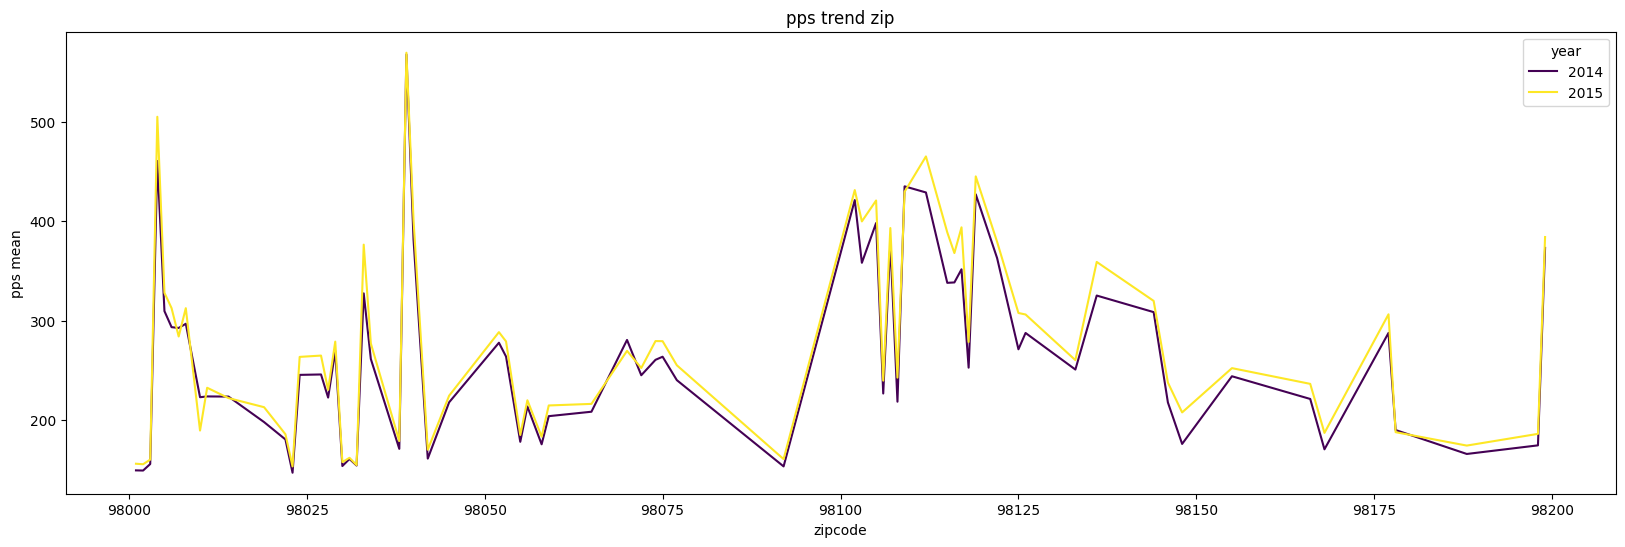

In [153]:
res['year'] = res['date'].dt.year  # extract year
price_trend = res.groupby(['zipcode', 'year'])['pps'].mean().unstack()
price_trend.plot(figsize=(20, 6), cmap='viridis')
plt.title('pps trend zip')
plt.ylabel('pps mean')
plt.show()

In [154]:
# Extract the year 
res['year'] = res['date'].dt.year

# Create  table: average price per square foot by zipcode and year
pps_trend = res.groupby(['zipcode', 'year'])['pps'].mean().unstack()

# Calculate %
first_year = pps_trend.columns.min()
last_year = pps_trend.columns.max()
pps_growth = ((pps_trend[last_year] - pps_trend[first_year]) / pps_trend[first_year]) * 100

# Combine  table 
pps_trend_with_growth = pps_trend.copy()
pps_trend_with_growth['growth_%'] = pps_growth.round(2)

# Sort top 10 zipcodes
pps_trend_with_growth = pps_trend_with_growth.sort_values('growth_%', ascending=False)

# Display 
print("Top 10 Zipcodes with Highest PPS Growth (%):")
print(pps_trend_with_growth)

Top 10 Zipcodes with Highest PPS Growth (%):
year           2014        2015  growth_%
zipcode                                  
98148    175.813442  207.539071     18.05
98115    337.954760  388.739870     15.03
98033    327.350992  376.384654     14.98
98125    271.068736  307.600161     13.48
98117    351.560220  393.778534     12.01
...             ...         ...       ...
98178    189.804468  187.654231     -1.13
98109    435.065769  429.592687     -1.26
98007    292.522788  283.948035     -2.93
98070    280.475945  269.502856     -3.91
98010    222.837561  189.305441    -15.05

[70 rows x 3 columns]


Inside 2 Location influence ROI. In 98148 the pps increase by 18.5 %, in decriece by 15.05%

Recomendation 2 buy in 98148 and sell it after.  Future analysis => time series forecast trend. Need more date.

3 Selling Time Affects Price 

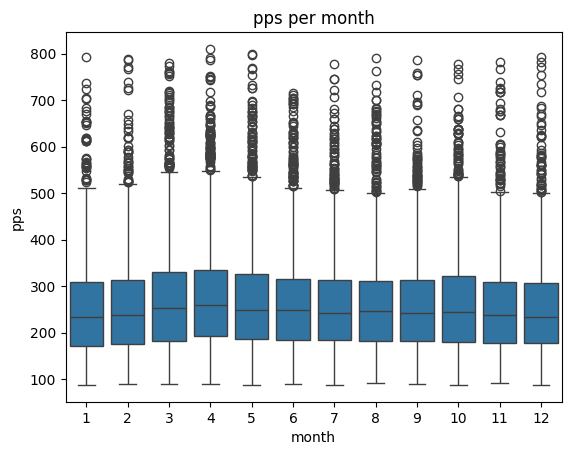

In [155]:
res['month'] = res['date'].dt.month
sns.boxplot(x='month', y='pps', data=res)
plt.title('pps per month')
plt.show()
# timing is relevant

In [158]:
# 1. Extract month and month name
res['month'] = res['date'].dt.month
res['month_name'] = res['date'].dt.month_name()

# 2. Average PPS per month
pps_month = res.groupby('month_name')['pps'].mean().round(2)

# 3. Ensure calendar month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pps_month = pps_month.reindex(month_order)

# 4. Convert to DataFrame
pps_month_df = pps_month.reset_index()
pps_month_df.columns = ['month_name', 'pps']

# 5. Sort descending (top) and ascending (bottom)
top_months = pps_month_df.sort_values('pps', ascending=False).head(12)
bottom_months = pps_month_df.sort_values('pps', ascending=True).head(12)

# 6. Calculate percentage difference between cheapest and most expensive months
most_expensive_month = top_months.iloc[0]
cheapest_month = bottom_months.iloc[0]

# Price difference in percentage
price_difference_percent = ((most_expensive_month['pps'] - cheapest_month['pps']) / cheapest_month['pps']) * 100

# 7. Print results
print("🔼 Top 12 Months with Highest Average PPS:")
print(top_months) 

print("\n🔽 Bottom 12 Months with Lowest Average PPS:")
print(bottom_months)

# 8. Print price difference in percentage
print(f"\nPrice Difference between Cheapest and Most Expensive Month: {price_difference_percent:.2f}%")

🔼 Top 12 Months with Highest Average PPS:
   month_name     pps
3       April  278.84
2       March  273.81
4         May  269.11
5        June  264.81
9     October  262.40
7      August  259.94
1    February  259.77
6        July  259.74
8   September  259.38
10   November  258.50
0     January  256.77
11   December  254.69

🔽 Bottom 12 Months with Lowest Average PPS:
   month_name     pps
11   December  254.69
0     January  256.77
10   November  258.50
8   September  259.38
6        July  259.74
1    February  259.77
7      August  259.94
9     October  262.40
5        June  264.81
4         May  269.11
2       March  273.81
3       April  278.84

Price Difference between Cheapest and Most Expensive Month: 9.48%


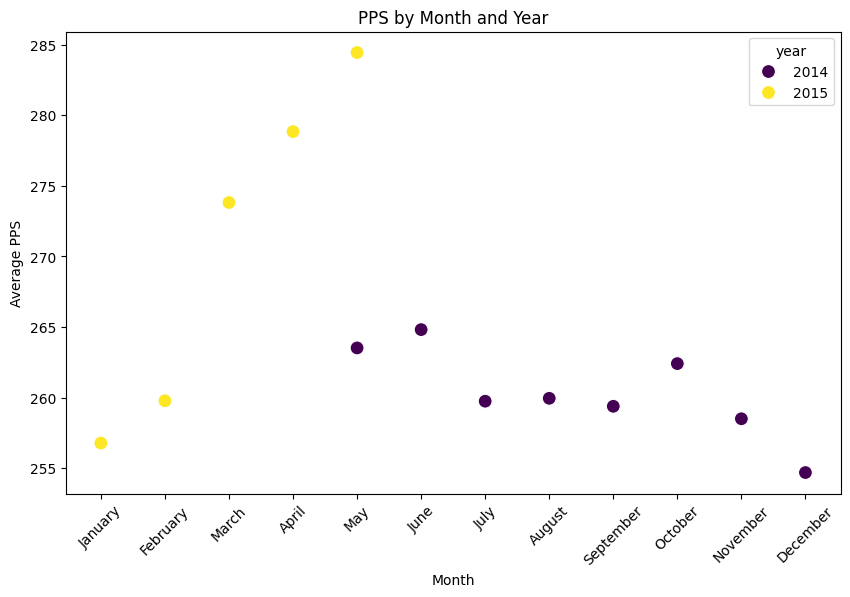

In [ ]:


# 1. Pivot table: average PPS per month for each year
res['year'] = res['date'].dt.year
pps_month_year = res.pivot_table(values='pps', index='month_name', columns='year', aggfunc='mean')

# 2. Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pps_month_year = pps_month_year.reindex(month_order)

# 3. Reshape data for scatterplot
pps_month_year_reset = pps_month_year.reset_index().melt(id_vars=['month_name'], var_name='year', value_name='pps')

# 4. Create scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pps_month_year_reset, x='month_name', y='pps', hue='year', palette='viridis', s=100)

# 5. Labels and title
plt.title('PPS by Month and Year')
plt.xlabel('Month')
plt.ylabel('Average PPS')

# 6. Rotate x-axis labels
plt.xticks(rotation=45)

# 7. Show plot
plt.show()

In [83]:
# Extract numeric month from date column
res['month'] = res['date'].dt.month

# Calculate correlation between month and price per square foot (pps)
correlation = res[['month', 'pps']].corr().round (2)

# Print the correlation matrix
print("Correlation matrix between month and PPS:")
print(correlation)

Correlation matrix between month and PPS:
       month   pps
month   1.00 -0.04
pps    -0.04  1.00


In [84]:
#use spearman corr, because not notmal distribution
res[['month', 'pps']].corr(method='spearman').round(2)

,month,pps
month,1.00,-0.03
pps,-0.03,1.00


3 Inside 3 Timing mace sence. Price Difference between Cheapest and Most Expensive Month: 9.48%. More date needed.  Future research on time series: check seasonality

Recomendation 3 buy in December and sell in April 